In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Bio import SeqIO
import json

/Users/gracenye/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Goals

In this notebook there are a few features of the data that we need to address. 

1. First, not all our RNA sequences are the same length. One common solution to this problem in the literature is to pad the RNA sequences (e.g. to just add Ns to the sequences so that they are all the same length as the maximum length RNA). 
2. Since our RNA sequences are too long to be run through a secondary structure prediction algorithm will any confidence, previous work has shown that dividing the RNA sequences into smaller overlapping windows is an appropriate solution, so we will divide our sequences into windows of ~100 nucleotides overlapping by ~50 nucleotides.
3. We will run the windowed sequences through an RNA secondary structure prediction algorithm in order to add an additional feature to our data since secondary structure information is relevant to protein binding. 
4. Finally, we must convert our RNA strings to data that can be interpreted by a machine learning algorithm. A common solution for this is to convert each nucleotide to a 1D vector so that each sequence is a 2D array of values.

In [2]:
ago1234 = pd.read_csv('../data/intermediate/ago1234.csv', index_col=0)
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1,334
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1,325
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1,320
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1,342
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1,352


In [3]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63118 entries, 0 to 276846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 63118 non-null  object
 1   sequence_identity  63118 non-null  object
 2   sequence           63118 non-null  object
 3   RBP_binding        63118 non-null  int64 
 4   seq_len            63118 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.9+ MB


In [4]:
ago1234.seq_len.describe()

count    63118.000000
mean       329.553455
std         22.673263
min         67.000000
25%        324.000000
50%        329.000000
75%        338.000000
max        375.000000
Name: seq_len, dtype: float64

In [5]:
#the maximum sequence length here is 375 nucleotides. if we increase this to 400 nucleotides per sequence, 
#then we can have six windows of 100 nucleotides with 50 nucleotide overlap per window

In [6]:
def pad_sequence(seq, max_len=400, pad='n'):
    seq_len = len(seq)
    if seq_len < max_len:
        to_add = max_len - seq_len
        new_seq = seq + (pad*to_add)
    return new_seq

In [7]:
ago1234['padded_seqs'] = [pad_sequence(seq) for seq in ago1234['sequence']]

In [8]:
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len,padded_seqs
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1,334,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1,325,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1,320,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1,342,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1,352,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...


In [9]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63118 entries, 0 to 276846
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 63118 non-null  object
 1   sequence_identity  63118 non-null  object
 2   sequence           63118 non-null  object
 3   RBP_binding        63118 non-null  int64 
 4   seq_len            63118 non-null  int64 
 5   padded_seqs        63118 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [10]:
ago1234['padded_len'] = [len(seq) for seq in ago1234['padded_seqs']]

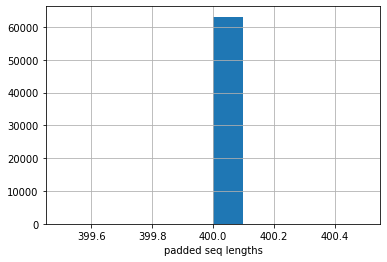

In [11]:
#as a sanity check that this operation worked
ago1234.padded_len.hist()
plt.xlabel('padded seq lengths')
plt.show()

In [12]:
##now we will separate them into seven windows, each 100 nucleotides, overlapping by 50 
def split_seq_into_windows(seq, window_size=100, shift=50):
    windows = []
    coords = []
    window_locs = [0, 50, 100, 150, 200, 250, 300]
    for i in window_locs:
        #print(i)
        windows.append(seq[i:i+window_size])
        coords.append(i)
    return windows, coords

In [13]:
ago1234_windows = {}
for index,row in ago1234.iterrows():
    windows_dict = {}
    seq = row['padded_seqs']
    ID = row['ID']
    windows, coords = split_seq_into_windows(seq)
    windows_dict['padded_seqs'] = seq
    windows_dict['ID'] = ID
    for window,coord in zip(windows,coords):
        windows_dict[f'window{coord}'] = window
    ago1234_windows[index] = windows_dict

In [14]:
ago1234_windows_df = pd.DataFrame(ago1234_windows).T
ago1234_windows_df.head()

,padded_seqs,ID,window0,window50,window100,window150,window200,window250,window300
0,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,"CID_041533;chrX,47028785,47028819,+",gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,ucccuccccauccuucuuccuccacuagugguggucguggugacag...,ggccgcuauggagccacugaccgcucgcaggaugaugguggggaga...,cagccgagaccacgacuaccgggacauggacuaccguucauauccu...,aguauggcagccaggagggcaagcaugacuaugacgacucaucuga...,cagagugcggaggugaggagggggcgcgcugcgccaggccuggcug...,gggcucccaagggcccucugugucuggcugcagcnnnnnnnnnnnn...
1,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,"CID_014973;chr15,90774588,90774613,-",guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,cagggucuucuccacauccccagccaaagacagccuuagcuuugag...,uccuggaucuccucaguguguucagugacacagccacgccagacau...,ucccauuaugccuuccgcaucuuuggugagaaccaggagcagcccg...,gacaccaccccuucccacgugggcuuugugguggcccugcuuggga...,ggcgccguuuggggaaccucagagccccucccaaccgugucuuuug...,ccugugucugcucucuagacuuugannnnnnnnnnnnnnnnnnnnn...
2,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,"CID_015737;chr16,30959327,30959347,+",ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,gcaaggagugggggccgcgggcagccgcucuucagcucgcggccca...,aguggcgaggggcgccccaacccccugcccgccucuccgcacaaua...,aacauucaucuguacugaaguguuacuugaaccgggggaaucucgg...,gggggagccggggugugaggggacuggaccagcuuggacugagacc...,accgggccggugggcgcccauuugggacugcgccacccccaggcuu...,uuguuuuacuguauugagcgnnnnnnnnnnnnnnnnnnnnnnnnnn...
3,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,"CID_025246;chr2,227661131,227661173,-",ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,ugcacaggugacuacaugaacaugucaccagugggggacuccaaca...,cagccccuccgacugcuacuacggcccugaggacccccagcacaag...,uccucuccuacuacucauugccaagauccuuuaagcacacccagcg...,ggggagccggaggagggugcccggcaucagcaccuccgccuuucca...,cucuggucgccuucucuaugcugcaacagcagaugauucuuccucu...,ccagcagcgacagccugggugggggauacugcggggcuaggcnnnn...
4,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,"CID_009003;chr12,6347000,6347052,+",gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,gauccucauguuucuuccuaucuccuagauauuuggcaugaucuuc...,ugaucuugugcugugcuauccgcaggaaccgcgagauggucuagag...,cuuacaucccugagcaggaaaguuuacccaugaagauuggugggau...,uguuuguuuguuuuguuuuguuuguuguuuguuguuuguuuuuuug...,uaauuuuaguauucauucugcauugcuagauaaaagcugaaguuac...,uguuugucuuuuaaugcuucauucaauauugacauuuguaguugag...


In [15]:
ago1234_windows_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63118 entries, 0 to 276846
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   padded_seqs  63118 non-null  object
 1   ID           63118 non-null  object
 2   window0      63118 non-null  object
 3   window50     63118 non-null  object
 4   window100    63118 non-null  object
 5   window150    63118 non-null  object
 6   window200    63118 non-null  object
 7   window250    63118 non-null  object
 8   window300    63118 non-null  object
dtypes: object(9)
memory usage: 4.8+ MB


In [16]:
ago1234 = ago1234.merge(ago1234_windows_df, on=['ID', 'padded_seqs'])

In [17]:
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len,padded_seqs,padded_len,window0,window50,window100,window150,window200,window250,window300
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1,334,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,400,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,ucccuccccauccuucuuccuccacuagugguggucguggugacag...,ggccgcuauggagccacugaccgcucgcaggaugaugguggggaga...,cagccgagaccacgacuaccgggacauggacuaccguucauauccu...,aguauggcagccaggagggcaagcaugacuaugacgacucaucuga...,cagagugcggaggugaggagggggcgcgcugcgccaggccuggcug...,gggcucccaagggcccucugugucuggcugcagcnnnnnnnnnnnn...
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1,325,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,400,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,cagggucuucuccacauccccagccaaagacagccuuagcuuugag...,uccuggaucuccucaguguguucagugacacagccacgccagacau...,ucccauuaugccuuccgcaucuuuggugagaaccaggagcagcccg...,gacaccaccccuucccacgugggcuuugugguggcccugcuuggga...,ggcgccguuuggggaaccucagagccccucccaaccgugucuuuug...,ccugugucugcucucuagacuuugannnnnnnnnnnnnnnnnnnnn...
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1,320,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,400,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,gcaaggagugggggccgcgggcagccgcucuucagcucgcggccca...,aguggcgaggggcgccccaacccccugcccgccucuccgcacaaua...,aacauucaucuguacugaaguguuacuugaaccgggggaaucucgg...,gggggagccggggugugaggggacuggaccagcuuggacugagacc...,accgggccggugggcgcccauuugggacugcgccacccccaggcuu...,uuguuuuacuguauugagcgnnnnnnnnnnnnnnnnnnnnnnnnnn...
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1,342,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,400,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,ugcacaggugacuacaugaacaugucaccagugggggacuccaaca...,cagccccuccgacugcuacuacggcccugaggacccccagcacaag...,uccucuccuacuacucauugccaagauccuuuaagcacacccagcg...,ggggagccggaggagggugcccggcaucagcaccuccgccuuucca...,cucuggucgccuucucuaugcugcaacagcagaugauucuuccucu...,ccagcagcgacagccugggugggggauacugcggggcuaggcnnnn...
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1,352,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,400,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,gauccucauguuucuuccuaucuccuagauauuuggcaugaucuuc...,ugaucuugugcugugcuauccgcaggaaccgcgagauggucuagag...,cuuacaucccugagcaggaaaguuuacccaugaagauuggugggau...,uguuuguuuguuuuguuuuguuuguuguuuguuguuuguuuuuuug...,uaauuuuaguauucauucugcauugcuagauaaaagcugaaguuac...,uguuugucuuuuaaugcuucauucaauauugacauuuguaguugag...


In [18]:
ago1234.info()
ago1234.to_csv('../data/intermediate/ago1234_windowed.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63118 entries, 0 to 63117
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 63118 non-null  object
 1   sequence_identity  63118 non-null  object
 2   sequence           63118 non-null  object
 3   RBP_binding        63118 non-null  int64 
 4   seq_len            63118 non-null  int64 
 5   padded_seqs        63118 non-null  object
 6   padded_len         63118 non-null  int64 
 7   window0            63118 non-null  object
 8   window50           63118 non-null  object
 9   window100          63118 non-null  object
 10  window150          63118 non-null  object
 11  window200          63118 non-null  object
 12  window250          63118 non-null  object
 13  window300          63118 non-null  object
dtypes: int64(3), object(11)
memory usage: 7.2+ MB


In [19]:
#now to write a function to repeat these operations for the other dataframes

def pad_and_window_seqs(csv_filename, max_len=400, window_size=100, shift=50):
    df = pd.read_csv(csv_filename, index_col=0)
    #quick sanity check 
    all_seq_lens = df['seq_len'].to_list()
    if max(all_seq_lens) > max_len:
        print('error, a sequence is longer than the max length')
    
    df['padded_seqs'] = [pad_sequence(seq) for seq in df['sequence']]
    df['padded_len'] = [len(seq) for seq in df['padded_seqs']]
    #another quick check
    df.padded_len.hist()
    plt.xlabel('padded seq lengths')
    plt.show()
    
    all_windows = {}
    for index,row in df.iterrows():
        windows_dict = {}
        seq = row['padded_seqs']
        ID = row['ID']
        windows, coords = split_seq_into_windows(seq)
        windows_dict['padded_seqs'] = seq
        windows_dict['ID'] = ID
        for window,coord in zip(windows,coords):
            windows_dict[f'window{coord}'] = window
        all_windows[index] = windows_dict
        
    windows_df = pd.DataFrame(all_windows).T
    df = df.merge(windows_df, on=['ID', 'padded_seqs'])
    
    return df

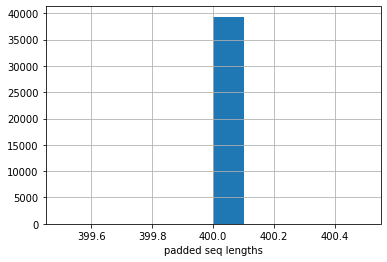

,ID,sequence_identity,sequence,seq_len,RBP_binding,padded_seqs,padded_len,window0,window50,window100,window150,window200,window250,window300
0,"cid_24084;chrX,53680075,53680107,-",positive_test,ugugaggcaauugcuuagcauaguaucuggcacauaaguuaguuca...,332,1,ugugaggcaauugcuuagcauaguaucuggcacauaaguuaguuca...,400,ugugaggcaauugcuuagcauaguaucuggcacauaaguuaguuca...,guaaauacaagccacuugguuuucaaaaaauguaaaaguaccuggc...,aucaccaaaagauaacaauaacauuuugcugcauuucuuccaguuu...,uguuuguuuguuuguuuugagacaggguuuugcucugucacacagg...,agugcaguggcacgaucacagcucacugcagccuugaccucccagc...,gcgaugcucccaccucagcuuccugaguagcugggaccauaggugc...,caccaugccuggcuaauuuuuuauuuuguguannnnnnnnnnnnnn...
1,"cid_6339;chr13,92163497,92163529,+",positive_test,aaauuugaguuuguaguuaaaugauugucucagaagcauuuccuuu...,332,1,aaauuugaguuuguaguuaaaugauugucucagaagcauuuccuuu...,400,aaauuugaguuuguaguuaaaugauugucucagaagcauuuccuuu...,auacagaauuccaauaugauguuucuuuuucccucuucgguacuuu...,augccuuucuauuguuuucuggccucaauuauuucagugagaagau...,guaauucauauauauuuuucccuauauggaaugcauucuguuuuuc...,acugcuuuuaguauauuuucuuucucuuugguuuucaggaauuuga...,uauauguccauuauuuggcuucucuuaauuuuauggcugauauuuu...,ucucuggguugauacauuucuuuugguuuggannnnnnnnnnnnnn...
2,"cid_7047;chr14,32590369,32590406,+",positive_test,uuuuuuuuuuuuuuuuuuuuggagacaggguucucucucuaacacc...,337,1,uuuuuuuuuuuuuuuuuuuuggagacaggguucucucucuaacacc...,400,uuuuuuuuuuuuuuuuuuuuggagacaggguucucucucuaacacc...,cugaagugcagagguguaacuucagcuaguugcaaccuccaccucc...,cucaggcaauccucccaccucagccucccaaauagcugggacugcc...,cacccagccaccuuuuuugguuuugguagaaacaggguuuugccau...,cccagccucgucucaaacuccugagcucaagcaaucuucccacaua...,uguucugaagucuacuuugccuaguauuaauauagccaauguuuuu...,uugaguaguguuugugauauaucuuuuucuuuacuuannnnnnnnn...
3,"cid_738;chr1,44765193,44765227,-",positive_test,uuugaacauuucucaccuuccuaggcccauuugcuugggccuuucu...,334,1,uuugaacauuucucaccuuccuaggcccauuugcuugggccuuucu...,400,uuugaacauuucucaccuuccuaggcccauuugcuugggccuuucu...,ucugucagauagagagugaaggcuggaagaccuuuuuucccaagcu...,gaaggaaccacuggugcuccuggaaaauauuuuccuuuguaugaga...,gcuuagaucuguguuuuuuuaaaacccuuuuugaacaucagcuagu...,gggucuuuaaaaaaaauugaggucugguauaguggcccacaccugg...,ccagugcuuugggaggcugaagcaggauuguuugaggccaggaguu...,accagccugagguagcagggcccugucucuauuannnnnnnnnnnn...
4,"cid_22458;chr8,128991034,128991066,+",positive_test,acaccuggcuaauuuuuuugugguuuuaguagagaugagguuucac...,332,1,acaccuggcuaauuuuuuugugguuuuaguagagaugagguuucac...,400,acaccuggcuaauuuuuuugugguuuuaguagagaugagguuucac...,uuguccaggcuggucuagaacucgugaaaacaggugauuugcccuc...,gccucccaaagugcugggauuacaggugugaaucaccgcacccgga...,uauuauuauaauuuuuuuuggagacaagguuuugcuuuguugccua...,ggaaugcaguggcagaaacauaacucaguguauucuugaacuccua...,uaagcugccuugcuaauguauuuacgugugugucuguguuuguagg...,acuauguugcccaggcugaucucaaacuccugnnnnnnnnnnnnnn...


In [20]:
hnrnpc = pad_and_window_seqs(csv_filename='../data/intermediate/hnrnpc.csv')
hnrnpc.head()

In [21]:
hnrnpc.to_csv('../data/intermediate/hnrnpc_windowed.csv')

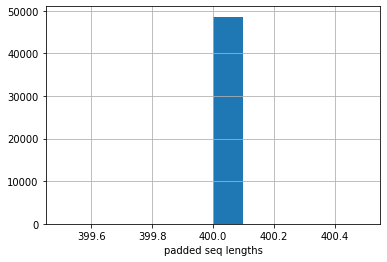

,ID,sequence_identity,sequence,RBP_binding,seq_len,padded_seqs,padded_len,window0,window50,window100,window150,window200,window250,window300
0,"CID_002575;chr1,156283921,156283954,-",positive_test,cuuucaugauuuccuugauuggcucugucauaaauccuacgaaguc...,1,333,cuuucaugauuuccuugauuggcucugucauaaauccuacgaaguc...,400,cuuucaugauuuccuugauuggcucugucauaaauccuacgaaguc...,acaacaucuggacacaguuugcuccugcagaaaucuauuguuuugg...,gauggcuuucauaagcuuuaucuauaacaacuguggcaucuucagu...,uaauccuuucauauuuucaucauguucucuuuguugggguucucuu...,aauguugacuuuuuuuuuuuuuuuuuuggagacagagucucgcucu...,ccaggcuggagugcaguggugugaucuuggcucacugcacccuccg...,cugguucaagcgauucuccugccucagccucccnnnnnnnnnnnnn...
1,"CID_005459;chr10,96368133,96368162,+",positive_test,guuugaggauaaaugaggucuaaagacaguaugaacuuguuaauaa...,1,329,guuugaggauaaaugaggucuaaagacaguaugaacuuguuaauaa...,400,guuugaggauaaaugaggucuaaagacaguaugaacuuguuaauaa...,uccuauuguccuuuuuagaaaucuuacauauccuuuagccuaauua...,uuggcccugcaagcaugucacuguaucuuuuaugucuuccugaguc...,cacuuuaaauucuucuauauccuucacugucuuucuuacagcaccc...,agaguagcaugugaacuguugcucuucucuaagguauuuuaggaca...,uaaaauaauauaugagugguugucaugcuaaauacugucuaccaca...,auacaauuaaaguggucaaagaaaggucunnnnnnnnnnnnnnnnn...
2,"CID_030395;chr5,145493419,145493445,-",positive_test,ucagaaccuuaggcuggaccuaaauagauugauuucauuucuaacc...,1,326,ucagaaccuuaggcuggaccuaaauagauugauuucauuucuaacc...,400,ucagaaccuuaggcuggaccuaaauagauugauuucauuucuaacc...,aauucugcauguauucauaauucuaucaagucaucuuugauuccug...,uaauaaauuuuuuuucccuuucuuuggguguccaagagaaaugguu...,ccaaacucuuuuuaaaaaacaaauuguugcuauuuccuagaaguuu...,uuuuuaagaugaacauaaaagugucaguaugcuucuuuuaugaggu...,uuuauacuuugaugaaggcuaagguguaccuaacagcuuuuuauag...,uucauuuauggaguuagcuguauuuunnnnnnnnnnnnnnnnnnnn...
3,"CID_009617;chr12,98941568,98941613,+",positive_test,aggagucuuuuucaucuaaauauguuccuaaguauguucccuuggc...,1,345,aggagucuuuuucaucuaaauauguuccuaaguauguucccuuggc...,400,aggagucuuuuucaucuaaauauguuccuaaguauguucccuuggc...,gucaagucagaaaagacaaaaaagggacgcuccauucccguaugga...,aauuuugcuguuuguuguuguggcaguuuuuuuguuuuuggucuau...,cuauggaaaccaaccaaguaaaucccuucucuaauuuucuucaugu...,ccuagaaaauccaacugaaugguaucucuuuggcacguucaacuug...,ccuauuuucaauaacuguugaaaaacauuuguguacacuuguugac...,agaacuaaaaauaaugugauuucgccucaauaaauguaguauuucn...
4,"CID_035058;chr8,614716,614750,-",positive_test,caaauauucagaauugagccacuguguugccauacugauuauguaa...,1,334,caaauauucagaauugagccacuguguugccauacugauuauguaa...,400,caaauauucagaauugagccacuguguugccauacugauuauguaa...,ugauuaacaaguauaaugugucacuuucaacaucaguuucaugcca...,ugcauuuuauuagauuauuugggaguucacuuugggcccaaaggcu...,ucuacauaauaauaacuuaugauuuuucuuuuugucuuuguuuuau...,uguuuuguguuuuuugcuuucuagaccaugccagaguaaucucagc...,uuuaguuacuggaucacacauauccuuccugagaagagcagugacu...,uggaauaucucuuuaagaacagcuccucuuuaacnnnnnnnnnnnn...


In [22]:
elavl1a = pad_and_window_seqs(csv_filename='../data/intermediate/elavl1a.csv')
elavl1a.head()

In [23]:
elavl1a.to_csv('../data/intermediate/elavl1a_windowed.csv')

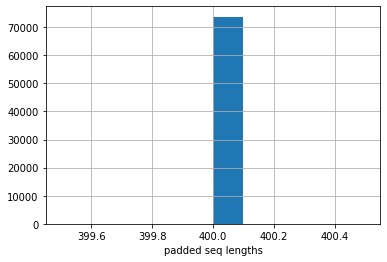

,ID,sequence_identity,sequence,RBP_binding,seq_len,padded_seqs,padded_len,window0,window50,window100,window150,window200,window250,window300
0,"cid_822;chr1,31501807,31501871,-",positive_test,auuaaauuaaaaaguaugagaaauagcuaacauaauucucaugaug...,1,364,auuaaauuaaaaaguaugagaaauagcuaacauaauucucaugaug...,400,auuaaauuaaaaaguaugagaaauagcuaacauaauucucaugaug...,uugcuuuuucauucauuuggauuuuguguuuuucauguuuugaaaa...,agggaaugggaggggagaaaguaggggucauugcugaacccugaug...,aagguaagugaauguuuaaucucuuagucacuugaucauugcuauu...,uugccaaugucugaaaguaaacauagaauaaauuuucaauugugug...,guguauguaaaauucaagaugcugacuugaagauuuuuccuucucu...,uaaacaauaggugcguuccauggaugaacugaaucaugauuuucaa...
1,"cid_8722;chr11,61919476,61919533,+",positive_test,auaucuucaagaagagcaagccccgcuaucacaagcgcaccagcuc...,1,357,auaucuucaagaagagcaagccccgcuaucacaagcgcaccagcuc...,400,auaucuucaagaagagcaagccccgcuaucacaagcgcaccagcuc...,gucuggaacucaccgccccugcagggcgccaggguccccagcagcc...,cuacagccugaagaagcacugaggcuggccugcggccuucuuggca...,cgccuccuguccaugucuaucugucugucugucggucucugucuug...,guugcccuccuucuuggcaugccauuguggagggcuuggccaggug...,uaaacguccucugugcuggguguuucugcugcagguggcagguggc...,ggccuguuuggaggaugggcuggguggguggguggggaagaaaugg...
2,"cid_25818;chr2,96858720,96858758,-",positive_test,auuucuuuaguauccaauguacucacgggauuauguuuauguucgg...,1,338,auuucuuuaguauccaauguacucacgggauuauguuuauguucgg...,400,auuucuuuaguauccaauguacucacgggauuauguuuauguucgg...,auaguguggaucaggaaaacaacaugaugguguuggugucgcggua...,uggcugccuguggcuguugccgaguuccuuuagcuguggccuucau...,acguaccugaguuuguauauucuuaguguccuaugagucucccaca...,ucccugcagccagugccccuuccauccagcuagaagaugagggacu...,cugucuagaaagaauggagagauacaagcuuuuaguuaaacuguuu...,ggguucuuuaauguugguaaucaaaagaagugcuguugnnnnnnnn...
3,"cid_47473;chr8,138917864,138917895,+",positive_test,uugauuuuucuguuuagagaaaugaggacaaaaacaugaacuuaau...,1,331,uugauuuuucuguuuagagaaaugaggacaaaaacaugaacuuaau...,400,uugauuuuucuguuuagagaaaugaggacaaaaacaugaacuuaau...,gcucacucuccucaucucaacucuuaagugcuggcuuuuacuuuuc...,gcaucugcccugaacuggaauuugggcucugggaucugggaaugcc...,ucggagaggugaggcuuugggaaauaaacucaaaaaaaaaaaaaaa...,aagaaaagaaagaaagaaaaagcagcagagagcaggcugaugggaa...,agacagaagggcaaggccaguaaugcccacuccuauacaaauagcu...,gugccugucugucaggagugacauccugcucnnnnnnnnnnnnnnn...
4,"cid_15287;chr14,53385787,53385854,-",positive_test,uuggaccuuagauaaguaugguauucaggcagaugcuaagcuucag...,1,367,uuggaccuuagauaaguaugguauucaggcagaugcuaagcuucag...,400,uuggaccuuagauaaguaugguauucaggcagaugcuaagcuucag...,ccccucagcacaaacugcuccgccugcagcuucccaacaugaagua...,aaggugaaagugaauuucucugauagagucuucaaagcuguuucug...,cuguaagacuuuuaguaaguauuacauaaauucuucuuaaaauacg...,augugauguacagaugaccgaugacugacauagcuuaucccaaggg...,ggcaugggcugaacuaucuguauauauguaugugugugaaauuucu...,cauuaaaguuuuuauauuaagauaaaugcuggguuaagguggaaca...


In [24]:
tial1 = pad_and_window_seqs(csv_filename='../data/intermediate/tial1.csv')
tial1.head()

In [25]:
tial1.to_csv('../data/intermediate/tial1_windowed.csv')

### Eternafold

Now to run each window through Eternafold. 

Eternafold is available for download here: https://eternagame.org/software
Here is the paper explaining how it works and the datasets it was trained on: https://www.nature.com/articles/s41592-022-01605-0
I will be accessing it through a wrapper that is available in arnie (a github repo designed by the Das Lab at Stanford, which created Eternafold and which I am currently a member of): https://github.com/DasLab/arnie

Eternafold is an RNA secondary structure prediction algorithm. This means it can predict whether two nucleotides will pair with each in a given RNA sequence. This is relevant information to the task of predicting protein binding with an RNA since the secondary structure of the RNA will influence where the protein will bind. 

For the sake of processing speed, I have run the secondary structure prediction task on Sherlock, the Stanford computing cluster. The script I used for this task can be found in the scripts directory in the main repo (spawn_eternafold_jobs.py and eternafold_preds.py) 

Since Eternafold does not predict pairing probabilities for non-standard nucleotides, I will exclude the n's from the calculation. I will pad the length of the p_paired probabilities with nans for now and will decide what value to replace them with for training the model down the line. 

At this stage, due to the length of time it requires for Eternafold to predict the base-pairing probabilities of sequences for each dataset, I will have to move forward with only a single dataset for the time being. 


In [26]:
json_files = os.listdir('../data/eterna/')
print(len(json_files))

900


In [27]:
eterna_dicts = []
for idx,file in enumerate(json_files):
    f = open(f'../data/eterna/{file}')
    data = json.load(f)
    eterna_dicts.append(data)
    f.close()

In [28]:
print(len(eterna_dicts))
print(len(eterna_dicts[0]))

900
487


In [29]:
print(eterna_dicts[0].keys())
print(eterna_dicts[0]['0'].keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [30]:
## what do we want the ultimate format of this dictionary to be? 

## want the outer dictionary keys to be the ID

## then a nested dictionary for each ID containing the 'window_num':p_net_base_pairing

## we will start with the ago1234 dataframe and take each ID
## then iterate through all eterna dictionaries until we find all seven dictionaries with the seven windows 
## initialize a new dictionary and fill out the necessary info

In [31]:
eterna = {}
for index,row in ago1234.iterrows():
    ID_dictionary = {}
    ID = row['ID']
    for dictionary in eterna_dicts:
        for key in dictionary.keys():
            #print(key)
            if dictionary[key]['ID'] == ID:
                ID_dictionary[dictionary[key]['window_num']] = dictionary[key]['p_net_base_pairing']
    eterna[ID] = ID_dictionary

In [32]:
print(len(eterna.keys()))
print(eterna['CID_041533;chrX,47028785,47028819,+'].keys())

63118
dict_keys(['window0', 'window50', 'window100', 'window150', 'window200', 'window250', 'window300'])


In [33]:
# need to run something to add on 0s whenever the window size is not 100 

for key in eterna.keys():
    if len(eterna[key].keys()) != 7:
        for i in range(0, 301, 50):
            try:
                print(eterna[key][f'window{i}'])
            except:
                eterna[key][f'window{i}'] = [0 for i in range(101)]
    else:
        for i in range(0, 301, 50):
            p_net_bp = eterna[key][f'window{i}']
            if len(p_net_bp) < 100:
                to_add = 100-len(p_net_bp)
                padded_p_net_bp = p_net_bp + [0 for i in range(to_add+1)]
                eterna[key][f'window{i}'] = padded_p_net_bp

[0.4910870592999999, 0.5114967594000002, 0.7195177692000002, 0.20491789319999998, 0.0097897678, 0.9548840973999999, 0.9883544639999998, 0.9860966005000001, 0.9646400108000001, 0.8319908839, 0.6775063507, 0.6935292052, 0.6884683095, 0.6267405998000001, 0.5742704035, 0.0016408453999999999, 0.0012638839999999998, 0.667803767, 0.663304294, 0.4327809869999999, 0.8668254580000001, 0.9100598001000001, 0.9559467146999999, 0.8949312300000003, 0.7470390534, 0.877653819, 0.6772265581999999, 0.667209678, 0.7859412750000001, 0.7449319549999999, 0.7036745736000001, 0.687767337, 0.276816496, 0.4433731223, 0.5580929716, 0.5000282886999999, 0.5373463037, 0.2602065994, 0.213746453, 0.1351399469, 0.19316722300000003, 0.598074778, 0.269550132, 0.5516693264, 0.436854045, 0.587532622, 0.9128594523999999, 0.8473136862000001, 0.7776296046999998, 0.7973814326, 0.5987303357, 0.8149307665000002, 0.7316441733000002, 0.5992268700000001, 0.241255253, 0.32228075500000003, 0.3663167464, 0.8949767662, 0.9507923733, 0.

[0.3113511005, 0.7289673086999999, 0.694180293, 0.8052265937, 0.7889612356, 0.8312008268999999, 0.7386235568999999, 0.8438011008999998, 0.6899229469999999, 0.28410089619999995, 0.2594775163, 0.037657627299999996, 0.04792836200000001, 0.32481532799999996, 0.5985079773, 0.5832933327000002, 0.6631860977999999, 0.7866972332999999, 0.906659207, 0.8793069127000002, 0.8968077795000001, 0.8660061989000001, 0.17951024030000004, 0.053865097, 0.16443624999999998, 0.29367320700000005, 0.2581070978, 0.024431640999999997, 0.7678802996999999, 0.7703693564000001, 0.8979663699000001, 0.9444273087999999, 0.9312225111000001, 0.6066124386999999, 0.01019046, 0.14163736810000005, 0.2105090537, 0.3167401829, 0.3864211913000001, 0.022219409199999998, 0.010894068000000002, 0.297930851, 0.5967604638, 0.7475146192000003, 0.7573422461, 0.5644150127, 0.7761230251, 0.8354320219, 0.8074235524, 0.6710906660999999, 0.3056297881, 0.6194725046999999, 0.1891238436, 0.5530968962000001, 0.42119483980000005, 0.0371416240000

[0.0170797161, 0.199262359, 0.158835214, 0.20838531400000002, 0.22700178499999998, 0.5624710068, 0.5154985184, 0.32561025320000003, 0.158408938, 0.132769261, 0.11596063499999999, 0.7160703650000001, 0.8286406768, 0.8316968876999998, 0.0428500312, 0.9615289739000001, 0.9761142871999999, 0.9743133582, 0.9852066875, 0.9916229728000001, 0.9711714451000001, 0.9675182889999999, 0.8400050315, 0.0618323795, 0.09024969199999999, 0.12330152629999999, 0.6641467025999999, 0.4223375866, 0.4919131574000001, 0.0066119955, 0.9688716339000001, 0.9763448524, 0.9606259750000001, 0.970691268, 0.7173224500000001, 0.9054984194000001, 0.9758077665999999, 0.9682522368999998, 0.7168544287, 0.00214837, 0.6016154714999999, 0.07972463249999999, 0.7873104841, 0.6098055841, 0.007900741, 0.019423845, 0.01235879, 0.0383156406, 0.0071909871, 0.325373199, 0.6867736751000001, 0.37229627639999996, 0.032726565000000006, 0.6082897776999999, 0.7451387705000001, 0.9564221580000001, 0.9775437942000001, 0.9346793935000001, 0.0

[0.001834724, 0.00310947, 0.00622873, 0.002041896, 0.00123958, 0.0018113, 0.000538044, 0.004807535999999999, 0.0, 0.0, 0.011996208]
[0.476816334, 0.49656795870000003, 0.17110008390000003, 0.30468815499999996, 0.23731884419999996, 0.217660024, 0.40747706040000004, 0.0716148164, 0.8772030137000001, 0.9482356381000001, 0.9864982139999999, 0.9492547065, 0.9006476098, 0.9810277712, 0.9900760847, 0.977625821, 0.2045538908, 0.9571789889000001, 0.9487141630000001, 0.22962145930000005, 0.09260248, 0.762418123, 0.845102676, 0.979652104, 0.976451582, 0.39853670399999996, 0.3820070848, 0.5807844064, 0.6904987800000001, 0.7108112663, 0.5705533389999999, 0.2181518349, 0.5658200123999999, 0.8746211186, 0.9694810888, 0.9481248988000001, 0.6196318328, 0.21078718230000001, 0.6337491919999998, 0.6216960837000002, 0.6494214653, 0.5507547253999999, 0.27190705939999993, 0.5323076627000001, 0.6499830991, 0.802083341, 0.6488777764, 0.5889089573, 0.5847037893999999, 0.388305525, 0.16661818689999996, 0.36950921

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
#note that there will be missing windows where we did not solve for base paired probabilities because 
#the whole window is just padding 

In [35]:
save_file = open('../data/intermediate/eterna.json', 'w')
json.dump(eterna, save_file, indent=6)
save_file.close()

### Summary 

For this project, we needed to properly format the data so that we could engineer some additional features for it that will be very helpful to use in generating a CNN that can accurately predict RBP binding to a given RNA sequence. 

For this purpose, we first needed to pad the RNA sequences so that they were all the same length. We did this by extending each sequence to the same length by adding 'n' on to the end of the sequence. 